# 1. Setup environment

## 1.1 Install dependencies

In [1]:
# !pip install tensorflow==2.13.0 opencv-python matplotlib

## 1.2 Import dependencies

In [2]:
import numpy as np
import os
import pathlib
import datetime

import matplotlib.pyplot as plt
from matplotlib import patches
# from matplotlib.collections import PatchCollection
# from matplotlib import cm
# from matplotlib import animation

In [3]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# Importing Tensorflow - Funcitonal API
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Dropout, MaxPooling2D, Input, Flatten, BatchNormalization
# Import Metric calculation
from tensorflow.keras.metrics import Precision, Recall
#
import tensorflow as tf

2023-07-19 12:37:51.893427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 12:37:51.989062: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 12:37:52.466462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPIT/lib64:/usr/local/cuda/lib64:/home/paco/miniconda3/envs/tf/

In [4]:
# Set general options
np.set_printoptions(precision=8)
# tf.keras.backend.set_floatx('float64')

# %tensorboard --logdir logs/fit

## 1.3 Limit GPU growth

In [5]:
# Avoid Out of Memory (OOM) errors by setting GPU Memory Consuption Growth
# Without this, by default tensorflow uses all memory available
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Print Tensorflow version and GPU available
print("Tensorflow Version: {}".format(tf.__version__))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

2023-07-19 12:37:53.144603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.149641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.149747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Tensorflow Version: 2.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-19 12:37:53.152028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.152454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.152706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.528190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:37:53.528318: I tensorflow/compiler/xla/stream_executo

# 2. Load and preprocess Dataset

## 2.1 Define a preprocessing function

In [6]:
# Define a function to load the image and resize it and its label (ground truth)
@tf.function
def preprocess_path_rgb(file_path):
    '''
    Function that converts a file path to a normalized `img`:
    '''
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    # if file_path_str.rfind(".jpg") >= 0:
    #     img = tf.io.decode_jpeg(img, channels=3)
    # elif file_path_str.rfind(".png") >= 0:
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size of 100x100x3
    img = tf.image.resize(img, [200, 200])
    # Scaling image to be between 0 and 1
    img = img / 255.0

    # Return the image
    return img

## 2.2 Create dataset

In [7]:
# Create a Tensorflow Dataset through list_files
dataset_dir = tf.data.Dataset.list_files('images/*.png', shuffle=False)

In [8]:
# Build pipeline
dataset = dataset_dir.map(preprocess_path_rgb)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.batch(16)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)  

# 3. Model Loading

In [9]:
# Load model
model = tf.keras.models.load_model('gauge_value_estimator_model_200x200x3.h5')

# 4. Predictions

In [10]:
def plot_predictions(X, y, net_img_size=200):
    # Get number of samples in the batch
    n_samples = X.shape[0]

    # Create figure
    fig, axs = plt.subplots(ncols=4, nrows=int(n_samples/4), figsize=(12, 12))
    
    for sample_idx in range(0, n_samples):
        # Get subplot's row
        ax_row = int(sample_idx / 4)
        # Get subplot's col
        ax_col = int(sample_idx % 4)
        # Plot
        axs[ax_row][ax_col].imshow(X[sample_idx])
        # Plot center
        axs[ax_row][ax_col].plot(int(y[sample_idx][0] * net_img_size), int(y[sample_idx][1] * net_img_size), color='blue', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Mark 1 - Minimum at scale (x1, y1)
        axs[ax_row][ax_col].plot(int(y[sample_idx][2] * net_img_size), int(y[sample_idx][3] * net_img_size), color='green', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Mark 2 - Maximum at scale (x2, y2)
        axs[ax_row][ax_col].plot(int(y[sample_idx][4] * net_img_size), int(y[sample_idx][5] * net_img_size), color='yellow', marker='x', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Plot Gauge Mark - Point of the tail (xv, yv)
        axs[ax_row][ax_col].plot(int(y[sample_idx][6] * net_img_size), int(y[sample_idx][7] * net_img_size), color='blue', marker='+', linewidth=2, 
                                 markersize=12, markeredgewidth=4)
        # Do not display the axis
        axs[ax_row][ax_col].axis('off')
        #
        # axs[ax_row][ax_col].set_title(f'{sample_idx}')

    plt.tight_layout()
    plt.show()

In [11]:
test_input = dataset.as_numpy_iterator().next()

y_hat = model.predict([test_input])
y_hat

2023-07-19 12:37:56.037860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


2023-07-19 12:37:57.176774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


array([[0.49698856, 0.38904577, 0.36491787, 0.44795573, 0.54595524,
        0.518571  , 0.5341311 , 0.34881637]], dtype=float32)

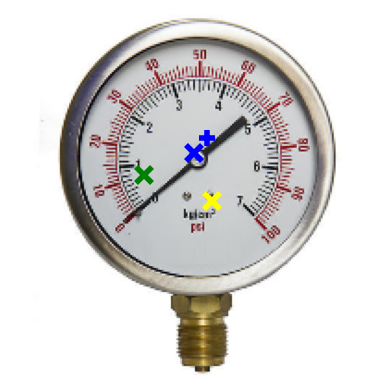

In [12]:
net_img_size = 200
sample_idx = 0
img = test_input[sample_idx]

plt.imshow(img)
# Plot center
plt.plot(int(y_hat[sample_idx][0] * net_img_size), int(y_hat[sample_idx][1] * net_img_size), color='blue', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Mark 1 - Minimum at scale (x1, y1)
plt.plot(int(y_hat[sample_idx][2] * net_img_size), int(y_hat[sample_idx][3] * net_img_size), color='green', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Mark 2 - Maximum at scale (x2, y2)
plt.plot(int(y_hat[sample_idx][4] * net_img_size), int(y_hat[sample_idx][5] * net_img_size), color='yellow', marker='x', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Plot Gauge Mark - Point of the tail (xv, yv)
plt.plot(int(y_hat[sample_idx][6] * net_img_size), int(y_hat[sample_idx][7] * net_img_size), color='blue', marker='+', linewidth=2, 
         markersize=12, markeredgewidth=4)
# Do not display the axis
plt.axis('off')
plt.show()